In [1]:
from torchvision.datasets import FashionMNIST as fm
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
lr = 1e-3
batch_size = 1024
n_epoch = 10

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize()
])
data_root = '/content/drive/Othercomputers/我的 MacBook Air/FasionMNIST'

fm_train = fm(root = data_root, train = True, download = False, transform = img_transform)
train_data = DataLoader(fm_train, batch_size = batch_size, shuffle = False)
fm_test = fm(root = data_root, train = False, download = False, transform = img_transform)
test_data = DataLoader(fm_test, batch_size = batch_size, shuffle = False)

In [4]:
class VAE_encoder(nn.Module):
    def __init__(self):
        super(VAE_encoder, self).__init__()
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                      out_channels = 16,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1), #shape out(16,28,28)
            nn.ReLU(),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.cnn2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,1),#shape out(32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
                                 )#(32,14,14)
        self.cnn3 = nn.Sequential(
            nn.Conv2d(32,128,3,1,1),
            nn.ReLU(),
                                 ) #(128,14,14)
        self.cnn4 = nn.Sequential(
            nn.Conv2d(128, 256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
                                 ) #(256,7,7)
        
        self.cnn_m = nn.Linear(256*7*7, 128)
        self.cnn_sigma = nn.Linear(256*7*7, 128)
        
    def forward(self,x):

        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = x.view(x.size(0), -1)#(batch_size,256*7*7)
        # define m , sigma
        m = self.cnn_m(x) #(batch_size,128)
        sigma = self.cnn_sigma(x) #(batch_size,128)
        
        # define e
        e = torch.randn_like(sigma)
        
        #define c
        c = torch.exp(sigma) * e + m #(batch_size,128)
        
        return c, m, sigma

In [5]:
class VAE_decoder(nn.Module):
    def __init__(self):
        super(VAE_decoder, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ConvTranspose2d(
                      in_channels = 256,
                      out_channels = 256,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1,
                     ),
            nn.ReLU(),
            nn.BatchNorm2d(256)) #(batch_size,256,7,7)
        
        self.cnn2 = nn.Sequential(
            nn.ConvTranspose2d(256,128,5,2,2, output_padding = 1),# (batch_size,128,7,7)
            nn.ReLU(),
                                 )
        
        self.cnn3 = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,1,1), # (batch_size,64,14,14)
            nn.ReLU()
        )        
        self.cnn4 = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,2,2, output_padding = 1), #(batch_size, 32,28,28)
            nn.ReLU()
                                 )
        self.cnn5 = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
        )
        self.cnn6 = nn.Sequential(
            nn.ConvTranspose2d(16,1,5,1,2), #(batch_size, 1,28,28)
            nn.Sigmoid()
                                 )
        self.fc = nn.Linear(128, 256*7*7)
        
    def forward(self, input_data): # input: c, m, sigma
        
        x = input_data
        
        x = self.fc(x) #(32, *14*14)
        x = x.view(x.size(0), 256, 7, 7) #(batch_size,256,14,14)
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        output = x
        
        return output

In [6]:
class VAE_CNN_autoencoder(nn.Module):
    def __init__(self):
        super(VAE_CNN_autoencoder, self).__init__()
        
        self.encoder = VAE_encoder()
        self.decoder = VAE_decoder()
        
    def forward(self,x):
        encoder,m, sigma = self.encoder(x)
        decoder = self.decoder(encoder)
        
        return decoder, m, sigma

In [7]:
model = VAE_CNN_autoencoder().to(device)
criterion = nn.L1Loss(reduction = 'sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1, last_epoch=-1)

In [8]:
print("strat training....")

strat training....


In [10]:
losses = []

def train(epoch, train_loader):
    #trianing Net
    for batch_idx, (real_image, _) in enumerate(train_loader):
        
        real_image = real_image.to(device)
        
        fake_image, m, sigma = model(real_image)
        
        KLD = 0.5 * torch.sum(
            torch.pow(m, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (real_image.size(0)*28*28)
        
        MSE = criterion(fake_image, real_image)
        
        loss = KLD + MSE
        
        # updata parametor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print('epoch is: {}, Loss is:{:.4f}'.format(epoch+1, loss.data))
    
    real_image, _ = iter(test_data).next()
    real_image = real_image.to(device)
    fake_image, _, _ = model(real_image)
    
    
    
for epoch in range(n_epoch):
    train(epoch, train_data)
    scheduler.step()
    #save image
    
    #save_image(image, ./path())
    

#save_model
#torch.save(model, '/content/drive/MyDrive/Colab Notebooks/model/VAE_autoencoder_3.pth')

epoch is: 1, Loss is:37312.8125
epoch is: 2, Loss is:35122.0625
epoch is: 3, Loss is:32561.9551
epoch is: 4, Loss is:30812.8281
epoch is: 5, Loss is:28963.5195
epoch is: 6, Loss is:27414.3008
epoch is: 7, Loss is:26082.7090
epoch is: 8, Loss is:25449.1816
epoch is: 9, Loss is:24206.2227
epoch is: 10, Loss is:23708.8457


In [12]:
model_1 = torch.load('/content/drive/MyDrive/Colab Notebooks/model/VAE_autoencoder_3.pth')
model_1

VAE_CNN_autoencoder(
  (encoder): VAE_encoder(
    (cnn1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (cnn2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn3): Sequential(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (cnn4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn_m): Linear(in_features=12544, out_features=128, bias=True)
    (cnn_sigma): Linear(in_features=12544, out_features=128, bias=True)
  )
  (decoder): VAE_decoder(
    (cnn1): Sequential(
      (0): ConvTranspose2d(256, 256, 

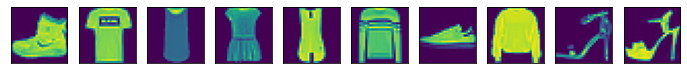

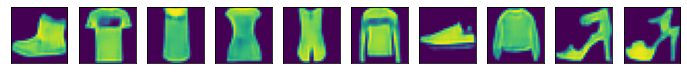

In [14]:
samples_in, samples_out = [], []
def show_fm(images):
    _, figs = plt.subplots(1, len(images), figsize = (12,12))
    for f, img in zip(figs, images):
        f.imshow(img.squeeze())
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
for i in range(10):
    samples_in.append(fm_train[i][0])
    sample_out,_,_ = model_1((fm_train[i][0]).reshape([1, fm_train[i][0].shape[0], fm_train[i][0].shape[1], fm_train[i][0].shape[2]]).to(device))
    sample_out = sample_out.cpu().detach().numpy()
    samples_out.append(sample_out)
show_fm(samples_in)
show_fm(samples_out)
